In [635]:
import pandas as pd
import numpy as np
import re # not really used atm
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [636]:
from sklearn.preprocessing import StandardScaler # to scale data
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

# NN model
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import SGD #test keras


In [637]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 60)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [638]:
def check_null(df):
    print('\ncheck null values \n')
    print('shape df: ', df.shape, '\n')
    ok_columns = [col for col in df if df[col].isna().sum() == 0]
    print('ok columns: ', ok_columns, '\n')
    for col in df:
        if df[col].isna().sum() >0:
            print(col, ':', df[col].isna().sum())

In [639]:
df_original = pd.read_csv('../input/output_print_1683.csv')

In [904]:
# define some useful variables
time_str = 'time_truth' 
#time_str = 'time_truth' 
use_t0 = 1
n_trk_used = 10

In [905]:
# remove rows with NaN (originating e.g. from empty lines in input file)
df_original = df_original[df_original['flav'].notna()] 

In [906]:
# check_null(df)

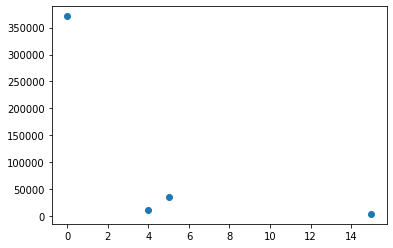

In [907]:
plt.scatter(df_original['flav'].value_counts().index, df_original['flav'].value_counts())

In [908]:
# do not consider PU jets
df = df_original[(df_original['truth_match']>0) & (df_original['quark_match']>0)]
# keep jets with pt>20 GeV, 2.5<eta<4
df = df[(df['jet_pt']>20) & (df['jet_eta']>2.5) & (df['jet_eta']<4)]
#df = df_original[(df_original['ele_match']<1)]
# for the moment I want to focus on b-vs-light --> keep only real light and b, and put target to flav=5
df = df[(df['flav']==0) | (df['flav']==5) ]
df['target'] = (df['flav'] == 5 ).astype(int)

In [909]:
# df[['truth_match','quark_match','ele_match']].describe()

In [910]:
# check how many events and the fraction of b-jets
df['target'].describe()

count    82976.000000
mean     0.330144    
std      0.470267    
min      0.000000    
25%      0.000000    
50%      0.000000    
75%      1.000000    
max      1.000000    
Name: target, dtype: float64

In [911]:
df = df.replace([-999],[0])

In [912]:
# change the track pT into fraction of the jet_pt
# change time into time-t0 (if no t0, t0 is set to zero so no difference)
for i in range(25):
    col = 'pt_trk'+'_'+str(i)
    df[col] = df[col]/df['jet_pt']
    if use_t0:
        col = time_str+'_'+str(i)
        df[col] = df[col]-df['t0']

In [913]:
df['avg_trk_time'] = 0
df.loc[df['n_trk']>0,'avg_trk_time'] = (sum(df[time_str+'_'+str(i)] for i in range(25)))/df['n_trk']

In [914]:
for i in range(25):
    if use_t0:
        df.loc[df['has_t0']<1,'time'+'_'+str(i)] = df[time_str+'_'+str(i)] - df['avg_trk_time']
    else:
        df['time'+'_'+str(i)] = df[time_str+'_'+str(i)] - df['avg_trk_time']

In [915]:
#check_null(df)

In [916]:
# df[['flav']+['pt_trk'+'_'+str(i) for i in range(n_trk_used)]].head()
# pfff, these are not pt ordered :( Probably pt-ordeered before calibration

In [917]:
# useful to make list of column names
trk_info = ["ValZ0","SigZ0","ValD0","SigZ0","IP3D_trk_pb","IP3D_trk_pu","IP3D_trk_pc","pt_trk","has_time","time","nhits","has_time_truth","time_truth","nhits_truth"]

In [918]:
columns_to_use = []
trk_info_to_keep = ["IP3D_trk_pb","IP3D_trk_pu", "has_"+time_str, time_str,"nhits"]
for i in range(20):
    for info in trk_info_to_keep:
        columns_to_use.append(info+'_'+str(i))

In [919]:
columns_to_use_df = columns_to_use[:]
columns_to_use_df += ['target']
if use_t0:
    columns_to_use_df += ['has_t0','t0']
df_to_use = df[columns_to_use_df]

In [920]:
#columns_to_use.remove('target')
# columns_to_use

In [921]:
# convert df into arrays
if use_t0:
    X = df_to_use[columns_to_use+['has_t0','t0']].values
else:
    X = df_to_use[columns_to_use].values
y = df_to_use['target'].values
# scaling
sc = StandardScaler()
X = sc.fit_transform(X) 

In [922]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

In [923]:
# Neural network
model = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model.add(Dense(300, input_dim=len(columns_to_use)+(2*use_t0), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
# loss function and optimizer
#opt = SGD(lr=0.001)
#model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model.fit(X_train, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test,y_test)) # show accuracy on test data after every epoch

Train on 62232 samples, validate on 20744 samples
Epoch 1/10
62232/62232 [==============================] - 5s 81us/step - loss: 0.3258 - acc: 0.8708 - val_loss: 0.3165 - val_acc: 0.8750
Epoch 2/10
62232/62232 [==============================] - 5s 78us/step - loss: 0.3081 - acc: 0.8787 - val_loss: 0.3112 - val_acc: 0.8785
Epoch 3/10
62232/62232 [==============================] - 5s 82us/step - loss: 0.3023 - acc: 0.8800 - val_loss: 0.3097 - val_acc: 0.8794
Epoch 4/10
62232/62232 [==============================] - 5s 83us/step - loss: 0.3005 - acc: 0.8815 - val_loss: 0.3106 - val_acc: 0.8801
Epoch 5/10
62232/62232 [==============================] - 5s 83us/step - loss: 0.2976 - acc: 0.8813 - val_loss: 0.3099 - val_acc: 0.8785
Epoch 6/10
62232/62232 [==============================] - 5s 88us/step - loss: 0.2951 - acc: 0.8831 - val_loss: 0.3083 - val_acc: 0.8797
Epoch 7/10
62232/62232 [==============================] - 5s 86us/step - loss: 0.2925 - acc: 0.8840 - val_loss: 0.3103 - val_acc

In [924]:
# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


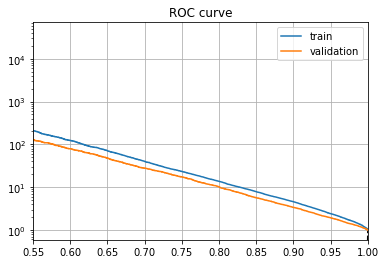

In [925]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, 1./fpr_test, label='validation')
#plt.xlabel('False positive rate')
#plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.yscale('log')
plt.xlim(0.55,1)
plt.grid(True)
plt.show()

In [926]:
type(X_train)

numpy.ndarray

In [927]:
X_train.shape

(62232, 102)

In [928]:
test = range(5*n_trk_used)

In [929]:
test2 = [i for i in test if i % 5 < 2]

In [930]:
X_train_no_HGTD = X_train[:,test2]
X_test_no_HGTD = X_test[:,test2]

In [931]:
X_train_no_HGTD.shape

(62232, 20)

In [932]:
# Neural network
model2 = Sequential() # creating model sequentially (each layer takes as input output of previous layer)
model2.add(Dense(300, input_dim=len(test2), activation='relu')) # Dense: fully connected layer
# model.add(Dense(50, activation='relu'))
# model.add(Dense(20, activation='relu')) 
model2.add(Dense(1, activation='sigmoid')) # chiara: check what's the best activation function for single-value output
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
# training 
history = model2.fit(X_train_no_HGTD, y_train, epochs=10, batch_size=50, # it was 100 epochs
                    validation_data = (X_test_no_HGTD,y_test)) # show accuracy on test data after every epoch

Train on 62232 samples, validate on 20744 samples
Epoch 1/10
62232/62232 [==============================] - 5s 74us/step - loss: 0.3265 - acc: 0.8706 - val_loss: 0.3199 - val_acc: 0.8732
Epoch 2/10
62232/62232 [==============================] - 4s 71us/step - loss: 0.3203 - acc: 0.8738 - val_loss: 0.3186 - val_acc: 0.8733
Epoch 3/10
62232/62232 [==============================] - 4s 70us/step - loss: 0.3191 - acc: 0.8731 - val_loss: 0.3191 - val_acc: 0.8737
Epoch 4/10
62232/62232 [==============================] - 4s 69us/step - loss: 0.3182 - acc: 0.8735 - val_loss: 0.3171 - val_acc: 0.8741
Epoch 5/10
62232/62232 [==============================] - 4s 69us/step - loss: 0.3173 - acc: 0.8751 - val_loss: 0.3173 - val_acc: 0.8742
Epoch 6/10
62232/62232 [==============================] - 4s 67us/step - loss: 0.3170 - acc: 0.8748 - val_loss: 0.3174 - val_acc: 0.8724
Epoch 7/10
62232/62232 [==============================] - 4s 66us/step - loss: 0.3167 - acc: 0.8747 - val_loss: 0.3203 - val_acc

In [933]:
# Prediction
y_pred_test_no_HGTD = model2.predict(X_test_no_HGTD)
y_pred_train_no_HGTD = model2.predict(X_train_no_HGTD)

fpr_test_no_HGTD, tpr_test_no_HGTD, thresholds_test_no_HGTD = roc_curve(y_test, y_pred_test_no_HGTD)
fpr_train_no_HGTD, tpr_train_no_HGTD, thresholds_train_no_HGTD = roc_curve(y_train, y_pred_train_no_HGTD)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


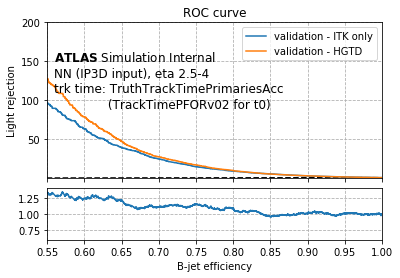

In [934]:
gs = gridspec.GridSpec(2, 1,
                       height_ratios=[3,1],
                       hspace=0.10)
ax1 = plt.subplot(gs[0])

plt.figure(1)
plt.text(0.02, 0.75, r'$\mathbf{ATLAS}$ Simulation Internal', size='large',transform=ax1.transAxes)
plt.text(0.02, 0.65, r'NN (IP3D input), eta 2.5-4', size='large',transform=ax1.transAxes)
plt.text(0.02, 0.55, r'trk time: TruthTrackTimePrimariesAcc', size='large',transform=ax1.transAxes)
plt.text(0.17, 0.45, r' (TrackTimePFORv02 for t0)', size='large',transform=ax1.transAxes)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(tpr_train_no_HGTD, 1./fpr_train_no_HGTD, label='train_no_HGTD')
one_over_fpr_test_no_HGTD = 1./fpr_test_no_HGTD
one_over_fpr_test = 1./fpr_test
plt.plot(tpr_test_no_HGTD, one_over_fpr_test_no_HGTD, label='validation - ITK only')
#plt.plot(tpr_train, 1./fpr_train, label='train')
plt.plot(tpr_test, one_over_fpr_test, label='validation - HGTD')
plt.ylabel('Light rejection')
plt.title('ROC curve')
plt.legend(loc='best')
#plt.yscale('log')
plt.xlim(0.55,1)
plt.ylim(1,200)
plt.grid(True,linestyle='--')
plt.gca().set_xticklabels(['']*10)

ax2 = plt.subplot(gs[1])
plt.xlim(0.55,1)
plt.ylim(0.6,1.4)
#np.interp([0, 1, 1.5, 2.72, 3.14], xp, fp)
one_over_fpr_test_plot = np.interp(tpr_test_no_HGTD, tpr_test, one_over_fpr_test)
ljr_ratio = np.divide(one_over_fpr_test_plot, one_over_fpr_test_no_HGTD)
plt.plot(tpr_test_no_HGTD, ljr_ratio)
plt.grid(True,linestyle='--')
plt.xlabel('B-jet efficiency')

plt.show()